In [59]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import sys
import os

# Add the parent directory of src to the path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.db.manager import DBManager
from src.input_to_instructions.load_and_execute import *
from src.input_to_instructions.types import *
from src.plot_graph.execute import *
from src.operation.execute import *

In [61]:
from collections import defaultdict, Counter
import logging

import pandas as pd
import numpy as np
from tqdm import tqdm
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import json
import itertools

from db.manager import DBManager
from operation.execute import OperationExecutor
from pathlib import Path
import warnings
import datetime


warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [62]:
BASE_DIR = "../"
def read_json(path):
    with open(path, "r", encoding="utf-8") as f:
        result = json.loads(f.read())
    
    # result = [{"Input": d["Input"], "Response": json.dumps(d["Response"], ensure_ascii=False)} for d in result]
    return result

In [63]:
def run_query(user_input, metadata, instructions):
    variables = {
        "Metadata": metadata,
    }
    for instruction in instructions:
        logger.debug(f"Executing instruction: {instruction.__class__.__name__}")
        print(f"Executing instruction: {instruction.__class__.__name__}")
        
        if type(instruction) == InstructionQ:
            # Execute query
            result_df = DBManager.structured_query_data_t(metadata, instruction.args)
            if result_df is None:
                print("죄송합니다, 관련 데이터를 찾을 수 없습니다.", "response")
                return

            # For demo, drop rows where any value is -1
            result_df = result_df.loc[(result_df != -1).all(axis=1)]
            print(f"QueryResult: {result_df}")

            variables[instruction.result_name] = result_df
        
        elif type(instruction) == InstructionO:
            # Execute operation

            result_dict = OperationExecutor.execute(variables, instruction.scripts, instruction.returns)
            variables.update(result_dict)
            pass
        elif type(instruction) == InstructionG:

            fig = plot_graph(instruction, variables)
            
            fig.show()
            # print(fig, "graph")
        elif type(instruction) == InstructionR:
            pass
            # # Execute response generation
            # variables_to_report = {k: v for k, v in variables.items() if k not in ["Metadata"]}
            # print(f"Variables: {variables_to_report}")
            # response, required_variables = ResponseGeneration.execute(instruction, variables, user_input, metadata)
            # print(f"Required variables: {required_variables}")
            
            # print(response, "response")

In [66]:
def build_query_groundtruth(dateset_name):
    def read(path):
        data = read_json(path)
        for i, d in enumerate(data):
            data[i]["Scenario"] = directory.name
            if "v7" in dateset_name:
                data[i]["Metadata"] = metadata
        return data

    ds_ts = []
    ds_tr = []
    base_dataset_dir = Path(f"{BASE_DIR}/finetuning/dataset/{dateset_name}")
    
    for directory in base_dataset_dir.iterdir():
        if directory.is_dir() and "scenario" in directory.name:
            if "v7" in dateset_name:
                metadata = read_json(f"{directory}/metadata.json")
            
            # ds_ts.extend(read(f"{directory}/onlyq_ts.json"))
            ds_tr.extend(read(f"{directory}/onlyq_tr.json"))
            # ds_tr.extend(read(f"{directory}/graph_temp.json"))
    
    ds = ds_ts + ds_tr
    
    # if "v7" in dateset_name:
    #     db_gt_filename = f"{BASE_DIR}/experiments/db_gt_v7.json"
    # else:
    #     db_gt_filename = f"{BASE_DIR}/experiments/db_gt.json"
    #     metadata = None
    
    # with open(db_gt_filename, "w", encoding="utf-8") as f:
        # f.write("[")
    # with tqdm(total=len(ds)) as pbar:
    for d in ds:
        # pbar.set_description(f"Processing {d['Input']}")
        # print("--")
        
        instructions = InputToInstruction.postprocess(d['Response'])
        user_input, tags, metadata, scenario = d["Input"], d["Tags"], d["Metadata"], d["Scenario"]
        run_query(user_input, metadata, instructions)

Executing instruction: InstructionQ
QueryResult:       settemp           timestamp     idu
0        23.0 2022-09-29 00:00:00  01_IB5
1        23.0 2022-09-29 00:01:00  01_IB5
2        23.0 2022-09-29 00:02:00  01_IB5
3        23.0 2022-09-29 00:03:00  01_IB5
4        23.0 2022-09-29 00:04:00  01_IB5
...       ...                 ...     ...
2827     23.0 2022-09-29 23:55:00  01_IB7
2828     23.0 2022-09-29 23:56:00  01_IB7
2829     23.0 2022-09-29 23:57:00  01_IB7
2830     23.0 2022-09-29 23:58:00  01_IB7
2831     23.0 2022-09-29 23:59:00  01_IB7

[2832 rows x 3 columns]
Executing instruction: InstructionO
Executing instruction: InstructionR
Executing instruction: InstructionQ
QueryResult:       roomtemp           timestamp     idu
0         25.5 2022-09-30 00:00:00  01_IB5
1         25.5 2022-09-30 00:01:00  01_IB5
2         25.5 2022-09-30 00:02:00  01_IB5
3         25.5 2022-09-30 00:03:00  01_IB5
4         25.5 2022-09-30 00:04:00  01_IB5
...        ...                 ...     ...


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_2702914/2391493705.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Executing instruction: InstructionQ
QueryResult:    settemp           timestamp     idu
0     23.0 2022-09-30 11:55:00  01_IB5
1     23.0 2022-09-30 11:56:00  01_IB5
2     23.0 2022-09-30 11:57:00  01_IB5
3     23.0 2022-09-30 11:58:00  01_IB5
4     23.0 2022-09-30 11:59:00  01_IB5
5     23.0 2022-09-30 12:00:00  01_IB5
Executing instruction: InstructionO
Executing instruction: InstructionR
Executing instruction: InstructionQ
QueryResult:    roomtemp  settemp           timestamp     idu
0      27.0     23.0 2022-09-30 11:55:00  01_IB7
1      27.0     23.0 2022-09-30 11:56:00  01_IB7
2      27.0     23.0 2022-09-30 11:57:00  01_IB7
3      27.0     23.0 2022-09-30 11:58:00  01_IB7
4      27.0     23.0 2022-09-30 11:59:00  01_IB7
5      27.0     23.0 2022-09-30 12:00:00  01_IB7
Executing instruction: InstructionO
Executing instruction: InstructionR
Executing instruction: InstructionQ
QueryResult:      roomtemp  settemp   oper           timestamp     idu
0        26.5     23.0  False 2022-

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_2702914/2391493705.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Executing instruction: InstructionQ
QueryResult:        oper           timestamp     idu
0     False 2022-09-29 00:00:00  01_IB5
1     False 2022-09-29 00:01:00  01_IB5
2     False 2022-09-29 00:02:00  01_IB5
3     False 2022-09-29 00:03:00  01_IB5
4     False 2022-09-29 00:04:00  01_IB5
...     ...                 ...     ...
1435  False 2022-09-29 23:55:00  01_IB5
1436  False 2022-09-29 23:56:00  01_IB5
1437  False 2022-09-29 23:57:00  01_IB5
1438  False 2022-09-29 23:58:00  01_IB5
1439  False 2022-09-29 23:59:00  01_IB5

[1440 rows x 3 columns]
Executing instruction: InstructionO
Executing instruction: InstructionR
Executing instruction: InstructionQ
QueryResult:     roomtemp           timestamp     idu
0       28.0 2022-09-30 11:55:00  01_IB5
1       28.0 2022-09-30 11:56:00  01_IB5
2       28.0 2022-09-30 11:57:00  01_IB5
3       28.0 2022-09-30 11:58:00  01_IB5
4       28.0 2022-09-30 11:59:00  01_IB5
5       28.0 2022-09-30 12:00:00  01_IB5
6       27.0 2022-09-30 11:55:00  01_I

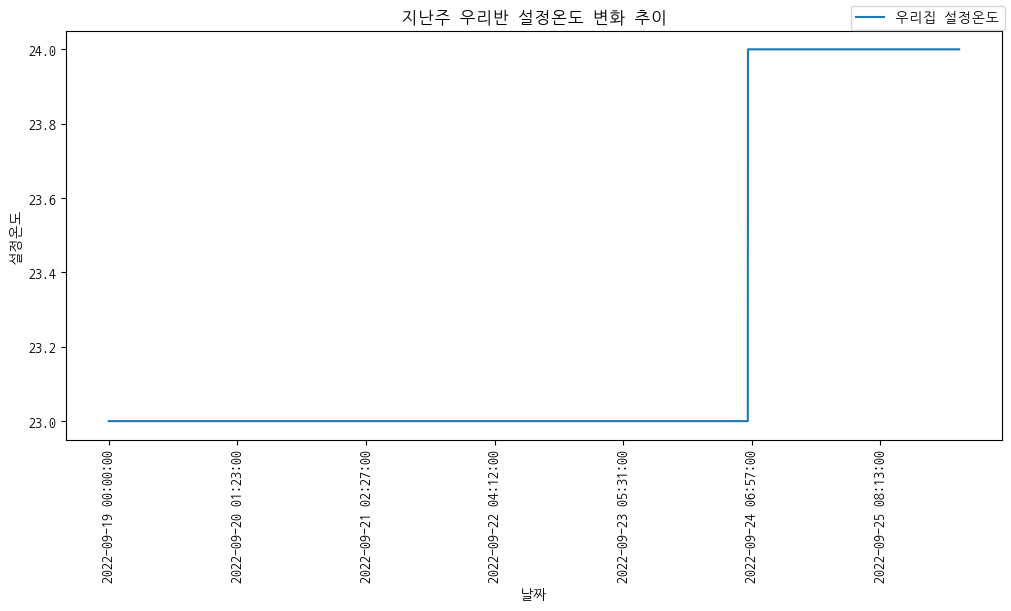

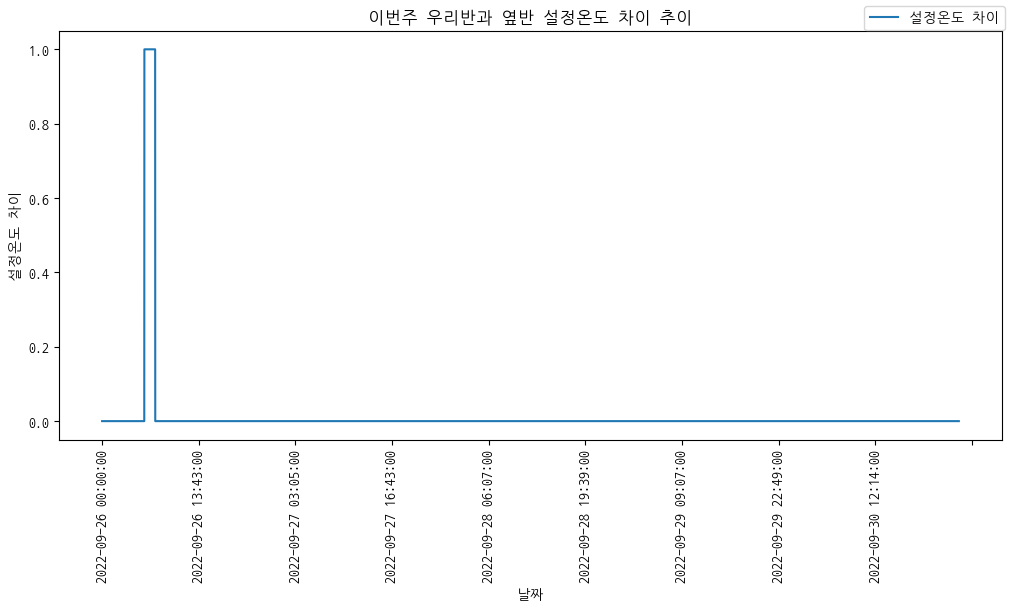

In [67]:
build_query_groundtruth("v7-250309-reduceinputanddatefunctioncall")